Note that this uses an older version of the prop file which is present in the old subfolder.

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from multislice import prop,prop_utils

Class - 'Multislice_simulation'

( All units in SI unless otherwise specified )

Inputs :

grid_beta  : grid of beta values <br>
grid_delta : grid of delta values <br>
pixel_size : 3x1 array of pixel sizes i.e. distance between nearest pixels in x,y and z directions <br>
energy     : energy of the xray beam in ev

In [2]:
class multislice_simulation(object):
    '''
    initialize the object
    wavefront is initialized to a plane wave
    '''
    def __init__(self,grid_beta,grid_delta,pixel_size,energy) :
        self.grid_beta  = grid_beta
        self.grid_delta = grid_delta
        self.pixel_size = pixel_size
        self.energy = energy
        self.wavel = (1240/self.energy)*10**(-9)
        self.wavefront = np.ones(np.shape(grid_beta[:,:,0]),dtype='complex64')
    '''
    used as part of the multislice loop
    '''
    def modify(self,slice_index):
        dist = self.pixel_size[-1]
        kz = 2 * np.pi * dist / self.wavel
        beta_slice = self.grid_beta[:,:,slice_index]
        delta_slice = self.grid_delta[:,:,slice_index]
        self.wavefront *= np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
        return 
    '''
    decide whether to use TF or IR approach depending on the distance
    '''
    def decide(self):
        dist = self.pixel_size[-1]
        sampling = np.sqrt(self.pixel_size[0]*self.pixel_size[1])
        L = sampling*np.shape(self.grid_beta[:,:,0])[0]
        critical = self.wavel*dist/L
        if sampling > critical :
            p = prop.propTF
            print('TF')
        else :
            p = prop.propIR
            print('IR')
        return p
    '''
    perform free space propogation using the method decided above
    '''
    def propogate(self,p):
        sampling = np.sqrt(self.pixel_size[0]*self.pixel_size[1])
        L = sampling*np.shape(self.grid_beta[:,:,0])[0]
        dist = self.pixel_size[-1]
        
        self.wavefront =  p(self.wavefront,sampling,L,self.wavel,dist)
        
        return
    '''
    multislice simulation.
    '''
    def simulate(self,N1=0,N2=0):
        p = self.decide()
        n = np.shape(grid_beta)[-1]
        output = []
        for i in range(n):
            self.modify(i)
            
            self.propogate(p)
            
            if i>N1 & i<N2:
                output.append(np.array(np.abs(self.wavefront),dtype='float16'))
        output = np.array(output)
        return output

In [3]:
grid_beta = np.load('grid_beta.npy')
grid_delta = np.load('grid_delta.npy')

In [4]:
sim = multislice_simulation(grid_beta,grid_delta,np.ones(3)*10**(-9),25000)
sim.simulate()

TF


array([], dtype=float64)

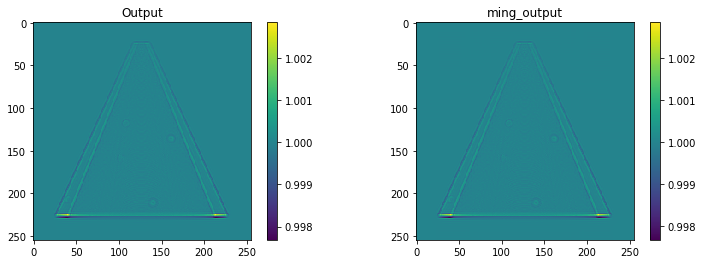

2.94135851808e-06


In [5]:
ming_output = np.load('ming_output.npy')
fig, (ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow((np.abs(sim.wavefront)))
ax1.title.set_text('Output')
fig.colorbar(im1,ax = ax1)
im2 = ax2.imshow(ming_output)
ax2.title.set_text('ming_output')
fig.colorbar(im2,ax = ax2)
fig.subplots_adjust(right=1.75)
plt.show()
print(np.sum( np.abs(sim.wavefront) -  ming_output))